<a href="https://colab.research.google.com/github/aoluwatooni/sentence-generator-for-indigenous-nigerian-language/blob/add-up/002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
!wget https://raw.githubusercontent.com/Niger-Volta-LTI/yoruba-text/master/Owe/owe.txt

--2022-09-08 05:14:54--  https://raw.githubusercontent.com/Niger-Volta-LTI/yoruba-text/master/Owe/owe.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180836 (177K) [text/plain]
Saving to: ‘owe.txt’

owe.txt             100%[===================>] 176.60K  --.-KB/s    in 0.003s  

2022-09-08 05:14:54 (66.4 MB/s) - ‘owe.txt’ saved [180836/180836]



In [3]:
with open('owe.txt') as f:
    data = f.readlines()    #Data loads as list
    
data = ''.join(data).lower().split('\n')      #Join Data into string,lower words and split along new lines
del data[0]
del data[-1]

In [4]:
print(len(data)) #showing the total values of the data

2700


In [5]:
#converting the data into a dataframe

import pandas as pd
import numpy as np

df = pd.DataFrame(data, columns=['owe'])
df.head()

,owe
0,a di gàárì sílẹ̀ ewúrẹ́ ńyọjú; ẹrù ìran rẹ̀ ni?
1,a kì í dàgbà má làáyà; ibi ayé bá báni là ńjẹ ẹ́.
2,àgbà kán ṣe bẹ́ẹ̀ lógùn; yemaja ló gbé e lọ.
3,"ibi tí oyín gbé ńhó, tí àdó ńhó, ìfun ò dákẹ́ ..."
4,ìdí òwò ni òwòó gbé tà.


In [6]:
#install the nltk-data libraries

!python -m nltk.downloader all

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nlt

In [7]:
#import nltk-data libraries to perform preprocessing

from nltk.stem import WordNetLemmatizer   #lemmatizer converts a word into a generic form
from nltk.corpus import stopwords         #used to remove common words in a sentence
from nltk.tokenize import word_tokenize   #split each sentence into a specific words (I can't find nltk-data for yoruba stopwords and i don't know how to use the one on the github repo)
import re

STOPWORDS = set(stopwords.words("english"))
MIN_WORDS = 3
MAX_WORDS = 200

#checkout the you cheatsheet for more context on how this works

PATTERN_S = re.compile("\'s")  # matches `'s` from text  
PATTERN_RN = re.compile("\\r\\n") #matches `\r` and `\n`
PATTERN_PUNC = re.compile(r"[^\w\s]") # matches all non 0-9 A-z whitespace


def clean_text(text):
    """
    Series of cleaning. String to lower case, remove non words characters and numbers.
        text (str): input text
    return (str): modified initial text
    """
    text = str(text).lower()  # lowercase text
    text = re.sub(PATTERN_S, ' ', str(text))
    text = re.sub(PATTERN_RN, ' ', str(text))
    text = re.sub(PATTERN_PUNC, ' ', str(text))
    return text

In [8]:
df['clean_owe'] = df['owe'].apply(clean_text)

In [9]:
df.head()

,owe,clean_owe
0,a di gàárì sílẹ̀ ewúrẹ́ ńyọjú; ẹrù ìran rẹ̀ ni?,a di gàárì sílẹ ewúrẹ ńyọjú ẹrù ìran rẹ ni
1,a kì í dàgbà má làáyà; ibi ayé bá báni là ńjẹ ẹ́.,a kì í dàgbà má làáyà ibi ayé bá báni là ńjẹ ẹ
2,àgbà kán ṣe bẹ́ẹ̀ lógùn; yemaja ló gbé e lọ.,àgbà kán ṣe bẹ ẹ lógùn yemaja ló gbé e lọ
3,"ibi tí oyín gbé ńhó, tí àdó ńhó, ìfun ò dákẹ́ ...",ibi tí oyín gbé ńhó tí àdó ńhó ìfun ò dákẹ ...
4,ìdí òwò ni òwòó gbé tà.,ìdí òwò ni òwòó gbé tà


In [10]:
#generating a unique token(values) for each of the words, Repeating words in the corpus are assigned the same token(values). This can be easily done using the Tokenizer in TensorFlow.

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer() #instantiating the tokenizer
corpus_data = data
tokenizer.fit_on_texts(corpus_data) #creates tokens for each words 
total_words = len(tokenizer.word_index) + 1 #calculating total number of words in the initial sentence

In [11]:
print(total_words)
print(tokenizer.word_index)

5150
{'a': 1, 'ní': 2, 'ò': 3, 'í': 4, 'kì': 5, 'ó': 6, 'bí': 7, 'bá': 8, 'tí': 9, 'tó': 10, 'ẹni': 11, 'fi': 12, 'kò': 13, 'ni': 14, 'ṣe': 15, 'ká': 16, 'o': 17, 'á': 18, 'kí': 19, 'là': 20, 'ti': 21, 'à': 22, 'ẹ̀': 23, 'kó': 24, 'òun': 25, 'yó': 26, 'rẹ̀': 27, 'ọmọ': 28, 'rí': 29, 'ló': 30, 'sí': 31, 'jẹ': 32, 'lọ': 33, 'ojú': 34, 'mọ': 35, 'pa': 36, 'lè': 37, 'má': 38, 'gbé': 39, 'jẹ́': 40, 'ohun': 41, 'ara': 42, 'fún': 43, 'ẹ́': 44, 'pé': 45, '”': 46, 'ọ́': 47, 'la': 48, 'kan': 49, 'tán': 50, 'ta': 51, 'wá': 52, 'máa': 53, 'ilé': 54, 'wọ́n': 55, 'é': 56, 'kú': 57, 'ọ': 58, 'sọ': 59, 'mú': 60, 'àgbà': 61, 'ẹní': 62, 'ajá': 63, 'ọjọ́': 64, 'di': 65, 'èèyàn': 66, 'ẹ': 67, 'baba': 68, 'i': 69, 'ibi': 70, 'gba': 71, 'gbọ́': 72, 'u': 73, 'orí': 74, 'e': 75, 'lójú': 76, 'mọ̀': 77, 'fẹ́': 78, 'ọ̀ràn': 79, 'mi': 80, 'sílẹ̀': 81, 'án': 82, 'dá': 83, 'lọ́wọ́': 84, 'ńpa': 85, 'ọwọ́': 86, 'ọmọdé': 87, 'ńṣe': 88, 'adìẹ': 89, 'gbogbo': 90, 'òún': 91, 'mọ́': 92, 'bó': 93, 'ẹnu': 94, 'wo': 95, 'inú

In [12]:
#storing generated sequences to another list
input_sequences = []

for gen_seq in corpus_data:
  # Converts each sentence as its tokenized equivalent
  newgen_list = tokenizer.texts_to_sequences([gen_seq])[0]
  
  for k in range(1,len(newgen_list)):
    #generating n_gram sequences: 1st two words in the token_list is one sequence, next two words are another sequence and so on
      n_gram_sequence = newgen_list[:k+1]
      #appending each n_gram sequence to the list of our features
      input_sequences.append(n_gram_sequence)
print("The training features are:\n",input_sequences)

The training features are:
 [[1, 65], [1, 65, 1361], [1, 65, 1361, 81], [1, 65, 1361, 81, 209], [1, 65, 1361, 81, 209, 985], [1, 65, 1361, 81, 209, 985, 228], [1, 65, 1361, 81, 209, 985, 228, 793], [1, 65, 1361, 81, 209, 985, 228, 793, 27], [1, 65, 1361, 81, 209, 985, 228, 793, 27, 14], [1, 5], [1, 5, 4], [1, 5, 4, 322], [1, 5, 4, 322, 38], [1, 5, 4, 322, 38, 2168], [1, 5, 4, 322, 38, 2168, 70], [1, 5, 4, 322, 38, 2168, 70, 142], [1, 5, 4, 322, 38, 2168, 70, 142, 8], [1, 5, 4, 322, 38, 2168, 70, 142, 8, 323], [1, 5, 4, 322, 38, 2168, 70, 142, 8, 323, 20], [1, 5, 4, 322, 38, 2168, 70, 142, 8, 323, 20, 110], [1, 5, 4, 322, 38, 2168, 70, 142, 8, 323, 20, 110, 44], [61, 431], [61, 431, 15], [61, 431, 15, 193], [61, 431, 15, 193, 2169], [61, 431, 15, 193, 2169, 2170], [61, 431, 15, 193, 2169, 2170, 30], [61, 431, 15, 193, 2169, 2170, 30, 39], [61, 431, 15, 193, 2169, 2170, 30, 39, 75], [61, 431, 15, 193, 2169, 2170, 30, 39, 75, 33], [70, 9], [70, 9, 2171], [70, 9, 2171, 39], [70, 9, 2171, 3

In [13]:
# Calculating the length of the longest sequence in our training features
max_sequence_len = max([len(x) for x in input_sequences])

#pre-pading each value of the input_sequence
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len,padding='pre'))
print(input_sequences)

[[   0    0    0 ...    0    1   65]
 [   0    0    0 ...    1   65 1361]
 [   0    0    0 ...   65 1361   81]
 ...
 [   0    0    0 ...   30   21  210]
 [   0    0    0 ...   21  210   18]
 [   0    0    0 ...  210   18   50]]


In [14]:
# Create predictors and label using numpy slicing
features = input_sequences[:,:-1]
labels = input_sequences[:,-1]

# Creating one hot encoding values of each labels 
labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# Modelling

**PS: One rule of thumb is that the embedding dimension should be approximately 1.6 times the square root of the number of unique elements in the category**

In [15]:
# Set embedding dimension for embedding layer
output_dim = int(np.sqrt(total_words) * 1.6)

In [29]:
# Creating a sequential model
model = Sequential()
# Adding an embedding layer with 64 as the embedding dimension
model.add(Embedding(total_words, output_dim=output_dim, input_length=max_sequence_len - 1))
# Adding 400 LSTM units
model.add(Bidirectional(LSTM(400)))
# Creating a dense layer with 5099 output units (total_words) with softmax activation
model.add(Dense(total_words, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 58, 114)           587100    
                                                                 
 bidirectional (Bidirectiona  (None, 800)              1648000   
 l)                                                              
                                                                 
 dense (Dense)               (None, 5150)              4125150   
                                                                 
Total params: 6,360,250
Trainable params: 6,360,250
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Compiling the model with adam optimiser
adam = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# Training for 500 epochs
history = model.fit(features,labels,epochs=50,verbose=1)

Epoch 1/50
816/816 [==============================] - 21s 16ms/step - loss: 6.8127 - accuracy: 0.0590
Epoch 2/50
816/816 [==============================] - 13s 16ms/step - loss: 6.0553 - accuracy: 0.1070
Epoch 3/50
816/816 [==============================] - 13s 16ms/step - loss: 5.4431 - accuracy: 0.1339
Epoch 4/50
816/816 [==============================] - 13s 16ms/step - loss: 4.6846 - accuracy: 0.1743
Epoch 5/50
816/816 [==============================] - 14s 17ms/step - loss: 3.8055 - accuracy: 0.2504
Epoch 6/50
816/816 [==============================] - 14s 17ms/step - loss: 2.9745 - accuracy: 0.3822
Epoch 7/50
816/816 [==============================] - 13s 17ms/step - loss: 2.2948 - accuracy: 0.5197
Epoch 8/50
816/816 [==============================] - 14s 17ms/step - loss: 1.7788 - accuracy: 0.6298
Epoch 9/50
816/816 [==============================] - 13s 16ms/step - loss: 1.3854 - accuracy: 0.7182
Epoch 10/50
816/816 [==============================] - 14s 17ms/step - loss: 1.099

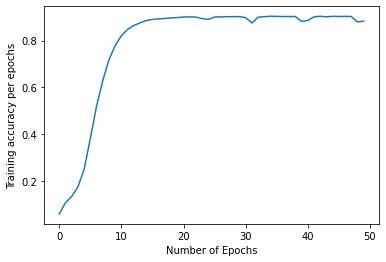

In [18]:
#plotting the training accuracy of the model
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.xlabel("Number of Epochs")
plt.ylabel('Training accuracy per epochs')
plt.show()

## Text Prediction. A seed text to start the predicted proverbs is preprocessed exactly as the training data is 

In [30]:
def generate_proverbs(seed_text,next_words):
    """ A function that takes a 
    seed_text: to prompt next word prediction
    next_word: The number of next words to predict
    and returns the predicted yoruba proverbs"""
    for _ in range(next_words):
       # Converting our seed_text to tokens and excluding the out of vocabulary words
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # Padding the seed_text
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
        # Predicting the token of the next word using our trained model
        predicted = model.predict(token_list, verbose=0)
        classes=np.argmax(predicted,axis=1)
        # Assigning empty string to output word 
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == classes:
              # Convert the token back to the corresponding word and storing it in the output_word
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

## Generate yoruba proverbs

In [31]:
data[34:38]

['ìṣeǹṣe ewúrẹ́, kágùntàn fiyè síi.',
 'àgbà kì í ṣorò bí èwe.',
 'iṣú ta iṣu ò ta, ọ̀kọ̀ọ̀kan là ńwúṣu lébè.',
 'ìtórò tó so lóko tí kò fẹ̀hìntì, afẹ́fẹ́ oko ní ńtú u.']

In [32]:
generate_proverbs('obinrin',10)

'obinrin àjẹlà èwe èwe èwe èwe àrífín èwe èwe àrífín àjẹlà'

In [33]:
generate_proverbs('àtẹnumọ',15)

'àtẹnumọ àjẹlà èwe èwe èwe èwe àrífín èwe èwe àrífín àjẹlà èwe èwe èwe èwe àrífín'

In [34]:
alist = ['Àjékú','Igbekele','Ìyànú']
for word in alist:
  print(generate_proverbs(word,10))

Àjékú àjẹlà èwe èwe èwe èwe àrífín èwe èwe àrífín àjẹlà
Igbekele àjẹlà èwe èwe èwe èwe àrífín èwe èwe àrífín àjẹlà
Ìyànú àjẹlà èwe èwe èwe èwe àrífín èwe èwe àrífín àjẹlà


In [24]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [25]:
##How to save and load the model with tf.keras
model.save("/content/gdrive/My Drive/yoruba_proverbs_generator_model_lstm_400b.h5")
model = tf.keras.models.load_model('/content/gdrive/My Drive/yoruba_proverbs_generator_model_lstm_400b.h5')

In [26]:
# Reset model 
from keras import backend as K
del model
K.clear_session()
tf.compat.v1.reset_default_graph()